### Democrat vs Republican Tweets Dataset

In [ ]:
# Processing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk, time, re, random, torch
! pip install accelerate -U
! pip install transformers[torch] -U
! pip install -U sentence-transformers
from collections import Counter
from statistics import mean
from transformers import RobertaTokenizerFast, BertTokenizer
from sentence_transformers import SentenceTransformer, util
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
# Loading the file
df = pd.read_csv("ExtractedTweets.csv", sep = ",")
df2 = df # Saving for later
df.head()

,Party,Handle,Tweet
0,Democrat,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P..."
1,Democrat,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...
2,Democrat,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...
3,Democrat,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...
4,Democrat,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...


#### EDA

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Removing the links
def remove_tokens(text):
    text = text.str.replace(r'https://\S+', '', regex = True)  # Remove URLs
    text = text.str.replace(r'@\S+', '', regex = True)         # Remove mentions
    text = text.str.replace(r'https…', '', regex = True)       # Remove https...
    text = text.str.replace(r'RT', '', regex = True)           # Remove RT
    return text

# Apply the function to the 'text_column'
df['Tweet'] = remove_tokens(df['Tweet'])

In [ ]:
num_tweets = len(df)
representatives = df.Handle.unique()
num_representatives = len(representatives)
print(f'Example tweet: {df["Tweet"][15]}')
print(f"There are {num_representatives} representatives and {num_tweets} tweets in total.")
print(f"Tweets per represeentative: {round(num_tweets/num_representatives, 2)} compared to expected 200")

# Dict with number of tweets per representative
tweets_per_rep: dict = {}
tweets_per_rep = dict(Counter(df['Handle']))
# Leaving only the representatives with exactly 200 tweets
reps_with_200 = [handle for handle, count in tweets_per_rep.items() if count == 200]
print(f"{len(reps_with_200)} representatives left out of {num_representatives}.")
# Filter the original DataFrame to only include reps with 200 tweets
filtered_df = df[df['Handle'].isin(reps_with_200)]
# Group tweets by user
grouped_tweets = filtered_df.groupby('Handle')['Tweet'].apply(lambda tweets: ' '.join(tweets)).reset_index()
grouped_tweets.head()
assert len(grouped_tweets) == len(reps_with_200), 'Number of unique handles does not match'
print(f"{int(len(filtered_df)/num_tweets * 100)}% of tweets retained.")

Example tweet: Meet 12 incredible young leaders appointed to US Military Academies from our District!  
There are 433 representatives and 86460 tweets in total.
Tweets per represeentative: 199.68 compared to expected 200
416 representatives left out of 433.
96% of tweets retained.


In [ ]:
average_length = []
for index, row in grouped_tweets.iterrows():
    average_length.append(len(row['Tweet']))
average_len = mean(average_length)
print(f'Average length of tweets (in characters) per rep: {average_len}, max length: {max(average_length)}')

Average length of tweets (in characters) per rep: 20755.75, max length: 23880


In [ ]:
grouped_tweets_lists = filtered_df.groupby('Handle')['Tweet'].apply(list).reset_index()
grouped_tweets_lists.head()

,Handle,Tweet
0,AGBecerra,[#Breaking: Court just granted our motion to i...
1,AlanGrayson,"[ 📻TUNE IN📻\n\nMy hubby, and I will join on..."
2,AnthonyBrownMD4,[ I've had the privilege of serving w some of ...
3,AustinScottGA08,"[This week, we have the opportunity to bring m..."
4,BennieGThompson,[ H.R. 4895 by passed the House yesterday (→...


In [ ]:
# Load the SBERT model
embedderSBERT = SentenceTransformer('all-MiniLM-L6-v2')
# Load the tokenizer (estimate num of tokens generated with a given threhold)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Leaving only the most similar tweets: S-BERT

Constructs a matrix of pairwise cosine similarity calculations for each user collection. Filters tweets according to thresholds between 0.40 and 0.9, with a step of 0.05.

In [ ]:
toks_and_sim = []
total_num_tokens = []
# Tracking how much the calculation takes
start_time = time.time()

similarity_thresholds = [0.40, 0.45, 0.5, 0.55, 0.60, 0.65, 0.70, 0.75, 0.8, 0.85, 0.9]

for similarity_threshold in similarity_thresholds:
    column_name = f"threshold_{similarity_threshold}"
    # Passing a column of empty lists
    grouped_tweets_lists[column_name] = np.empty((len(grouped_tweets_lists), 0)).tolist()

    # Break the text into paragraphs (assuming paragraphs is a list of strings)
    for index, row in grouped_tweets_lists.iterrows():
        paragraphs = row['Tweet']
        handle = row['Handle']

        # Encode paragraphs to get sentence embeddings with SBERT
        embeddings = embedderSBERT.encode(paragraphs, convert_to_tensor=True)

        # Compute cosine similarity matrix
        cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

        # Cluster paragraphs based on similarity
        extracted_paragraphs = set()
        for i in range(len(paragraphs)):
            for j in range(i + 1, len(paragraphs)):
                if cosine_scores[i][j] > similarity_threshold:
                    extracted_paragraphs.add(paragraphs[i])
                    extracted_paragraphs.add(paragraphs[j])

        # Ensure we have extracted paragraphs
        if not extracted_paragraphs:
            extracted_paragraphs = []
            grouped_tweets_lists.at[index, column_name] = []
            total_num_tokens.append(0)

        else:
            extracted_paragraphs = list(extracted_paragraphs)
            assert len(extracted_paragraphs) > 0, "No paragraphs extracted"
            grouped_tweets_lists.at[index, column_name] = extracted_paragraphs
            # Calculate the number of tokens
            tokked_paragraphs = [tokenizer(paragraph, padding=True, truncation=True, max_length = 512) for paragraph in extracted_paragraphs]
            flattened_toks = [item for sublist in tokked_paragraphs for item in sublist]
            num_tokens = len(flattened_toks)
            total_num_tokens.append(num_tokens)

    # If a user had no paragraphs selected, set num of tokens to 0
    if 0 in total_num_tokens:
        toks_and_sim.append(0) # means at least one user has a 0-paragraph collection & the threshold should not be used
    else:
        toks_and_sim.append(mean(total_num_tokens))

end_time = time.time()
execution_time = end_time - start_time

for sim, tok in zip(similarity_thresholds, toks_and_sim):
    print(f'Similarity threshold: {sim}, approx. number of tokens: {tok}.')

print(f'Execution time for all similarity threshold values: {execution_time}')

simandtokdata = {
    'Similarity Thresholds': similarity_thresholds,
    'Number of Tokens': toks_and_sim,
}
simandtokdata = pd.DataFrame.from_dict(simandtokdata)

Similarity threshold: 0.4, approx. number of tokens: 531.5697115384615.
Similarity threshold: 0.45, approx. number of tokens: 499.81009615384613.
Similarity threshold: 0.5, approx. number of tokens: 462.03846153846155.
Similarity threshold: 0.55, approx. number of tokens: 422.296875.
Similarity threshold: 0.6, approx. number of tokens: 382.9139423076923.
Similarity threshold: 0.65, approx. number of tokens: 345.4675480769231.
Similarity threshold: 0.7, approx. number of tokens: 311.21600274725273.
Similarity threshold: 0.75, approx. number of tokens: 0.
Similarity threshold: 0.8, approx. number of tokens: 0.
Similarity threshold: 0.85, approx. number of tokens: 0.
Similarity threshold: 0.9, approx. number of tokens: 0.
Execution time for all similarity threshold values: 3714.6125197410583


In [ ]:
# Manually drop columns with 0s
grouped_tweets_lists = grouped_tweets_lists.drop(columns=['threshold_0.75', 'threshold_0.8', 'threshold_0.85', 'threshold_0.9'])

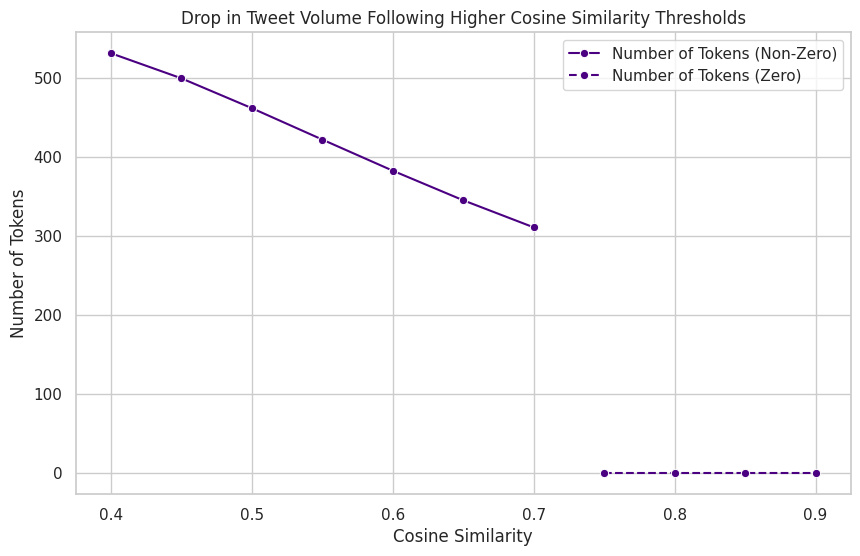

In [ ]:
# Find the index of the first zero in 'Number of Tokens'
zero_index = simandtokdata['Number of Tokens'].eq(0).idxmax()

# Split the data into two parts
data_non_zero = simandtokdata.loc[:zero_index-1]
data_zero = simandtokdata.loc[zero_index:]
plt.figure(figsize=(10, 6))

# Plot the non-zero segment
sns.lineplot(x='Similarity Thresholds', y='Number of Tokens', data=data_non_zero, marker='o', color='indigo', label='Number of Tokens (Non-Zero)')

# Plot the zero segment
sns.lineplot(x='Similarity Thresholds', y='Number of Tokens', data=data_zero, marker='o', color='indigo', linestyle='--', label='Number of Tokens (Zero)')

plt.title("Drop in Tweet Volume Following Higher Cosine Similarity Thresholds")
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Tokens')
plt.legend()
plt.show()

### Adding party affiliations (merging datasets on handles)  

In [ ]:
# Create a dictionary mapping each handle to its associated party
handle_to_party = df2.drop_duplicates('Handle').set_index('Handle')['Party'].to_dict()
print(handle_to_party)

In [ ]:
grouped_tweets_lists['Party'] = grouped_tweets_lists['Handle'].map(handle_to_party)
grouped_tweets_lists.head()

In [ ]:
grouped_tweets_lists.to_csv('/content/drive/My Drive/Dataset_versions.csv', index = True)